In [1]:
from importlib import reload

import torch
from torch import nn
from torch.utils.data import DataLoader

# %load_ext tensorboard

import dataset, model, trainer
import numpy as np
import util, config, zernike

{3: 0.3760888795766656, 4: 0.3072637413815287, 5: 2.4294902791920556, 6: -0.43236345857544645, 7: -0.38464714374692166, 8: -0.06914471847010395, 9: 0.1890906686529703, 10: 0.41682263391723184, 11: 0.3015027128213392, 12: 0.09786999651106532, 13: 0.21799958558457155, 14: -0.38742971215578914, 15: -0.39805027450243835, 16: -0.17264589583786782, 17: 0.29504300252649485, 18: -0.12117947170667409, 19: -0.28436987911021605, 20: 0.21417233459604168}


D:\Github\smlm-dl\smlm_dl\dataset.py:222: RuntimeWarning: invalid value encountered in log
  im = axes[1].imshow(np.log(tiled_images))


55:	 [id = 55.000,], [x = 0.159,], [y = 3.408,], [A = 1260.695,], [bg = 50.342,],
251:	 [id = 251.000,], [x = 1.386,], [y = -2.671,], [A = 1968.587,], [bg = 4.020,],
236:	 [id = 236.000,], [x = -0.295,], [y = -5.444,], [A = 1591.060,], [bg = 5.438,],
79:	 [id = 79.000,], [x = -6.475,], [y = 8.758,], [A = 1621.032,], [bg = 7.832,],
11:	 [id = 11.000,], [x = -2.842,], [y = 0.894,], [A = 1610.985,], [bg = 27.512,],
90:	 [id = 90.000,], [x = 6.733,], [y = -0.070,], [A = 1535.212,], [bg = 64.735,],
219:	 [id = 219.000,], [x = 1.766,], [y = -4.483,], [A = 1294.588,], [bg = 59.154,],
218:	 [id = 218.000,], [x = -10.604,], [y = 6.936,], [A = 1246.162,], [bg = 52.732,],
183:	 [id = 183.000,], [x = 1.695,], [y = -7.158,], [A = 1249.946,], [bg = 16.555,],
18:	 [id = 18.000,], [x = 8.439,], [y = 6.881,], [A = 666.429,], [bg = 67.893,],
236:	 [id = 236.000,], [x = 7.331,], [y = -8.203,], [A = 1661.134,], [bg = 89.673,],
215:	 [id = 215.000,], [x = 7.131,], [y = -0.726,], [A = 1415.922,], [bg = 34.4

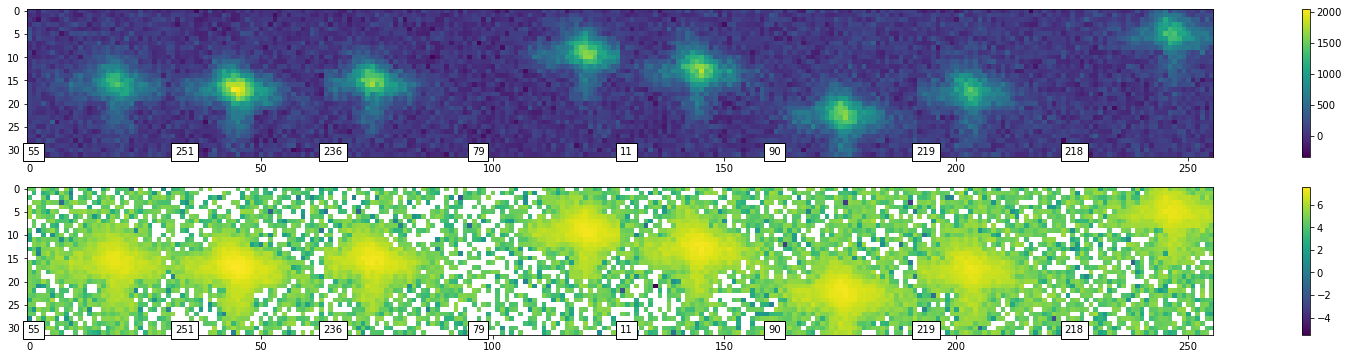

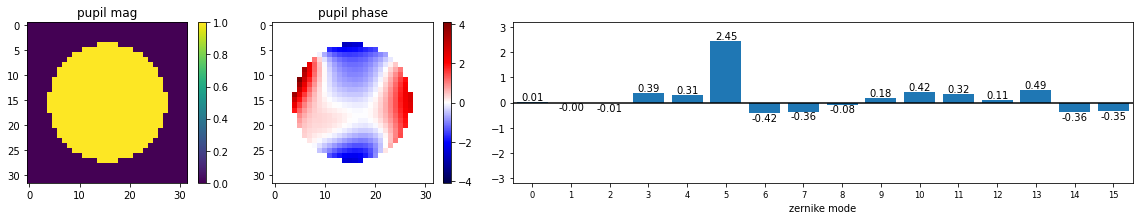

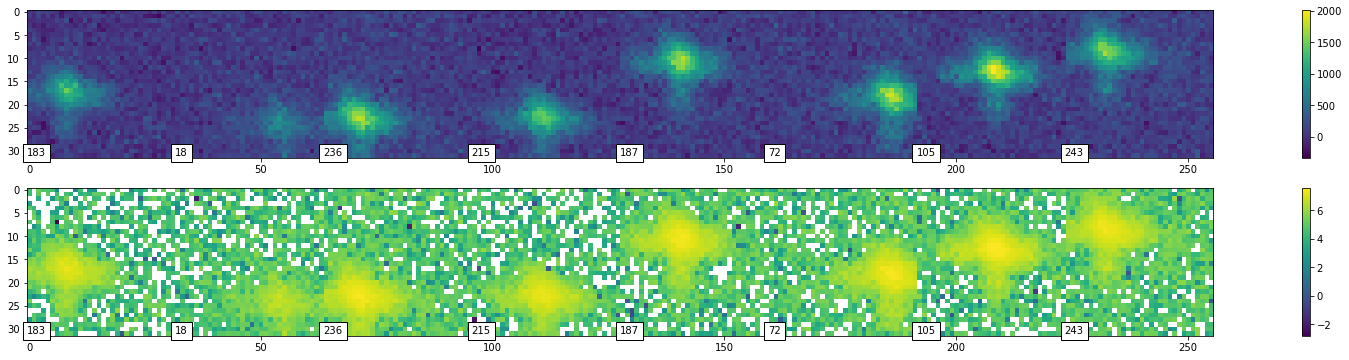

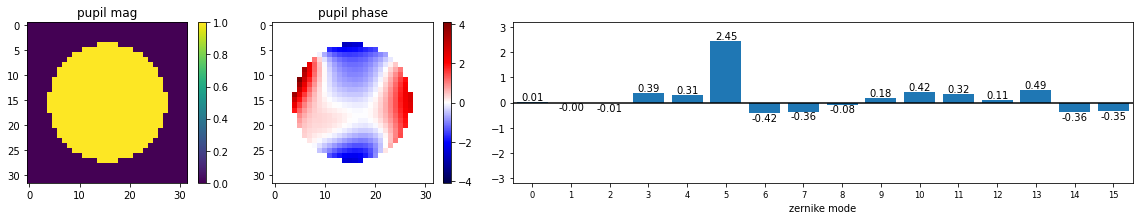

In [2]:
reload(dataset)

psf_zerns = dict()
for z in range(3, 21):
    psf_zerns[z] = np.random.uniform(-0.5, 0.5)
# psf_zerns.update({4:1, 5:2, 7:1, 12:0.5, })
# psf_zerns.update({5:2 })
psf_zerns[5] = np.random.uniform(0.5, 2.5)

print(psf_zerns)

settings = {
    # 'out_size': (64,64),
    'length': (256, 1),
    'dropout_p': 0,
    'psf_zerns': psf_zerns,
    # 'noise_params': {},
    'normalize': False,
    'padding': (4,4),
    'random_z': False,
    "augmentations":{},
    # "augmentations":{"pixel shift":(4,4), }#"add noise":0.1},
}

# training_data = dataset.FourierOptics2DPSFDataset(**settings)
# training_data = dataset.Gaussian2DPSFDataset(**settings)
training_data = dataset.FourierOpticsPSFDataset(**settings)

dataset.inspect_images(training_data)

train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True)


# valid_data = dataset.FourierOptics2DPSFDataset(**settings)
# valid_data = dataset.Gaussian2DPSFDataset(**settings)
valid_data = dataset.FourierOpticsPSFDataset(**settings)
dataset.inspect_images(valid_data)

valid_dataloader = DataLoader(valid_data, batch_size=256, shuffle=True)
valid_dataloader = train_dataloader

In [3]:
fit_params = ['x','y','sig','A','bg']
init_params = np.zeros((len(fit_params), len(train_dataloader.dataset), ))
print(init_params.shape)
init_params[0] = training_data.params['x'][:,0] * np.random.uniform(0.9, 1.0, len(train_dataloader.dataset))
init_params[1] = training_data.params['y'][:,0] * np.random.uniform(0.9, 1.0, len(train_dataloader.dataset))
init_params[2] = 5 * np.random.uniform(0.9, 1.0, len(train_dataloader.dataset))
init_params[3] = training_data.params['A'][:,0] * np.random.uniform(0.9, 1.0, len(train_dataloader.dataset))
init_params[4] = training_data.params['bg'] * np.random.uniform(0.9, 1.0, len(train_dataloader.dataset))
print(init_params[:,0])

(5, 256)
[  -5.09907911   -4.86646152    4.88967373 1550.30569026   80.90761682]


(5, 256)
torch.Size([5, 256])
{'x': [<act: Identity, offset: 0, scaling: 1, default: 0.0, per psf: True, >], 'y': [<act: Identity, offset: 0, scaling: 1, default: 0.0, per psf: True, >], 'sig': [<act: Identity, offset: 0, scaling: 1, default: 7, per psf: True, >], 'A': [<act: Identity, offset: 0, scaling: 1, default: 1000, per psf: True, >], 'bg': [<act: Identity, offset: 0, scaling: 1, default: 0, per psf: False, >]}
CUDA not available. Defaulting to CPU
Device: cpu


C:\Users\Kenny\anaconda3\envs\smlm-dl\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


input shape: torch.Size([256, 1, 32, 32]), output_shape: (256, 1, 32, 32)


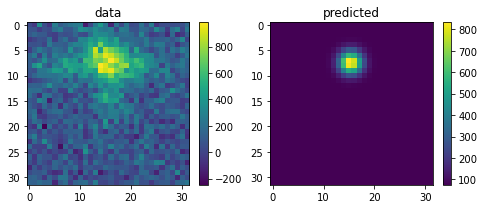

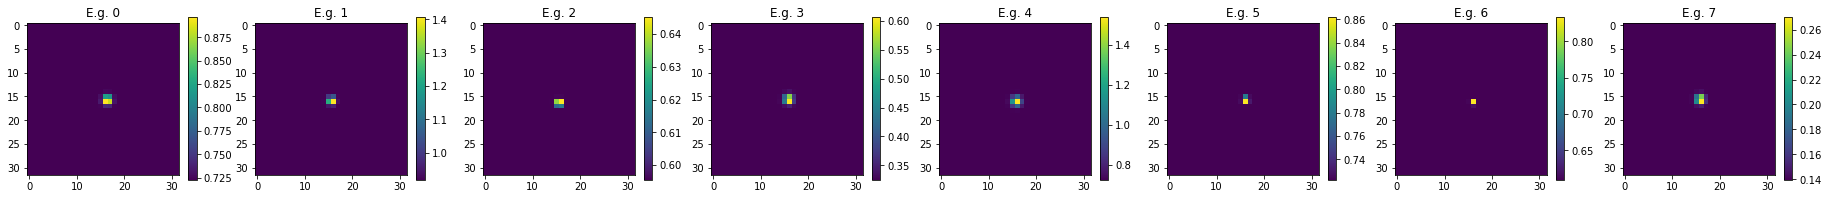

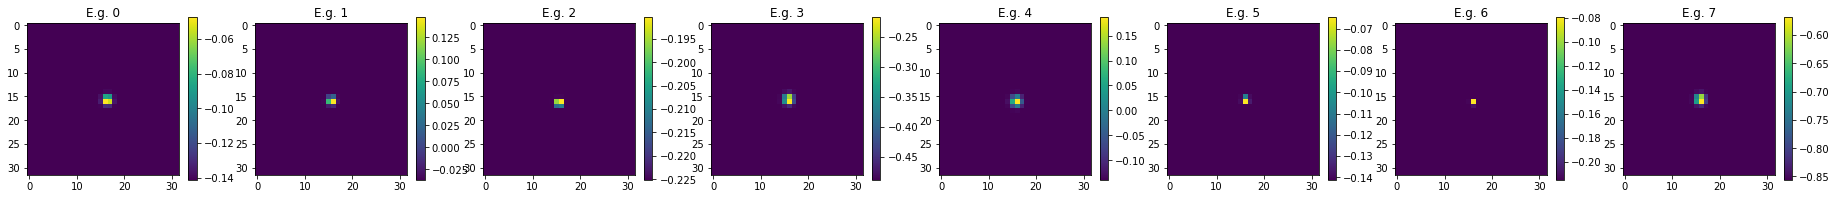

In [4]:
reload(trainer)
reload(model)
reload(util)
reload(zernike)

# params_ref_override = {
#     'x': model.FitParameter(nn.Hardtanh(), 0, 24, 0, True),
#     'y': model.FitParameter(nn.Hardtanh(), 0, 24, 0, True),
#     'A': model.FitParameter(nn.ReLU(), 0, 1000, 1, True),
#     'bg': model.FitParameter(nn.Tanh(), 0, 500, 0, False),
# }

# fitting_model = model.Gaussian2DModel(fit_params=['x','y','A','bg','sig',], max_psf_count=1, depth=3, skip_channels=0)

# sig_param = model.FitParameter(nn.ReLU(), 2, 1, 20, True)
# fitting_model = model.Gaussian2DModel(fit_params=['x','y','A','bg'], params_ref_override={'sig':sig_param}, max_psf_count=3)

# fitting_model = model.Template2DModel(
                                    # feedback_class=model.DirectConcatFeedbackModel,
                                    # feedback_class=model.DenseFeedbackModel,
                                     #  fit_params=['x','y','A','bg'],
                                     #  max_psf_count=1,
                                     # params_ref_override=params_ref_override,
                                     # )
# fitting_model =  model.FourierOptics2DModel(
#                                             feedback_class=model.DenseFeedbackModel,
#                                             # feedback_class=model.DirectConcatFeedbackModel,
#                                             img_size=(32,32),
#                                             fit_params=['x','y','z','A','bg'],
#                                             max_psf_count=1,
#                                             params_ref_override=params_ref_override,
#                                             encoder_params={"skip_channels":0},
#                                             renderer_params={"pupil_params":{'scale':0.75, 'apod':False, },}#'phase_init_zern':{5:2}},
#                                             )

fitting_model = model.Gaussian2DModel(encoder_class=model.IdEncoderModel,
                                      # img_size=(32,32),
                                      fit_params=fit_params,
                                      max_psf_count=1,
                                      encoder_params={"num_img":len(train_dataloader.dataset),
                                                      "init_weights":init_params,
                                          # "depth":3,
                                                      # "skip_channels":4,
                                                      # "first_layer_out_channels":16,
                                                     },
                                      params_ref_no_scale=True,
                                     )

print(fitting_model.fit_params)

# optimizer = torch.optim.AdamW(fitting_model.parameters(), lr=1e4)
optimizer = torch.optim.Adam(fitting_model.parameters(), lr=1e0)
# optimizer = torch.optim.SGD(fitting_model.parameters(), lr=1e-4)
# optimizer = torch.optim.LBFGS(fitting_model.parameters(), lr=1e-4)



# model_parameters = [param for param in fitting_model.parameters()
#                     # if (not param is fitting_model.renderer.template.parameter)]
#                     if (not param is fitting_model.renderer.pupil_magnitude.parameter) and 
#                     (not param is fitting_model.renderer.pupil_phase.parameter)]
# # print(model_parameters)

# optimizer = torch.optim.Adam([{"params" : fitting_model.encoder.parameters()},
#                               # {"params" : fitting_model.feedbacker.parameters(), "lr" : 1e-3},
#                               {"params" : fitting_model.renderer.parameters(), "lr" : 1e-2},
#                              ], lr=1e-3)


training = trainer.FittingTrainer(fitting_model, train_dataloader, valid_dataloader, optimizer)
!
# training.train_single_epoch()
# training.validate()

model.check_model(fitting_model, train_dataloader)

In [5]:
# training.load_checkpoint(r"D:\Github\smlm-dl\smlm_dl\checkpoints\Nov19_20-27-37_DESKTOP-7NNT713.ptc")
# len(train_dataloader.dataset)

Saved to : D:\Pytorch\runs\2021-12-10_20-56-12_DESKTOP-7NNT713_dFit_test\model.ptm


  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Saved to : D:\Pytorch\runs\2021-12-10_20-56-12_DESKTOP-7NNT713_dFit_test\checkpoint.ptc
model_state_dict: odict_keys(['encoder.encoders.scale.weight'])
optimizer_state_dict: dict_keys(['state', 'param_groups'])
loss_function_state_dict: odict_keys([])
log_path: D:\Pytorch\runs\2021-12-10_20-56-12_DESKTOP-7NNT713_dFit_test
epoch: 99
loss: 15647.5595703125


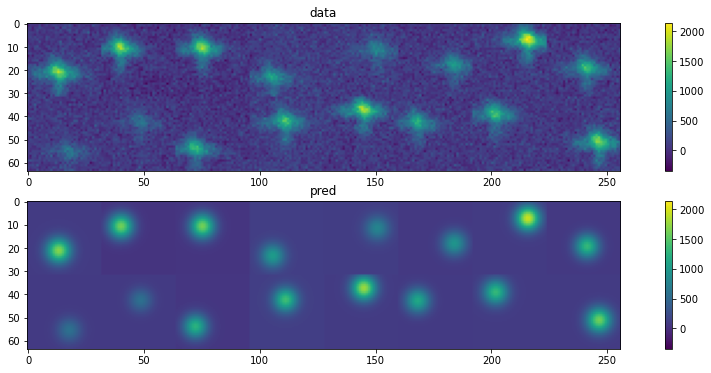

In [6]:
# from torch.utils.tensorboard import SummaryWriter
# training.train_and_validate(1000000, tb_logger=SummaryWriter())

training.train_and_validate(100, training_interval=1, validate_interval=1, label="dFit_test")
# training.train_single_epoch()
# training.validate()

input shape: torch.Size([256, 1, 32, 32]), output_shape: (256, 1, 32, 32)


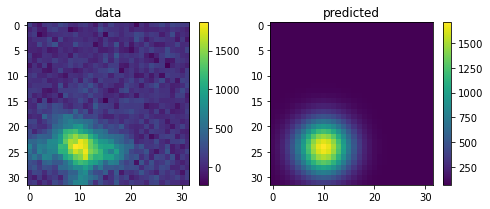

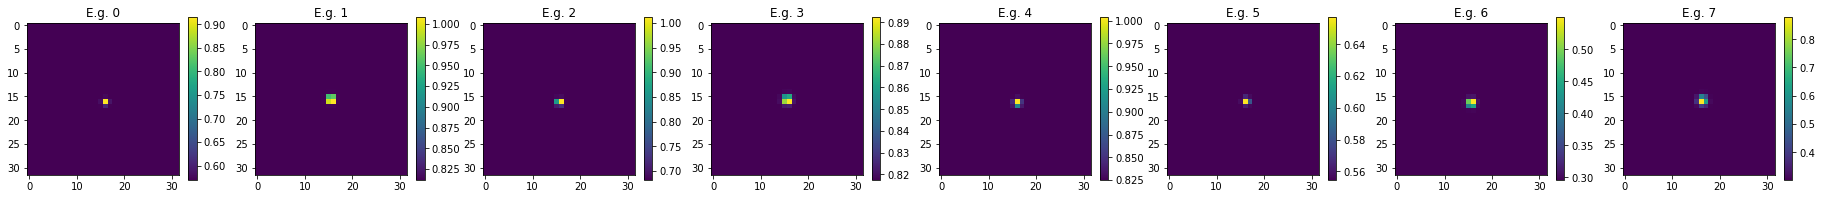

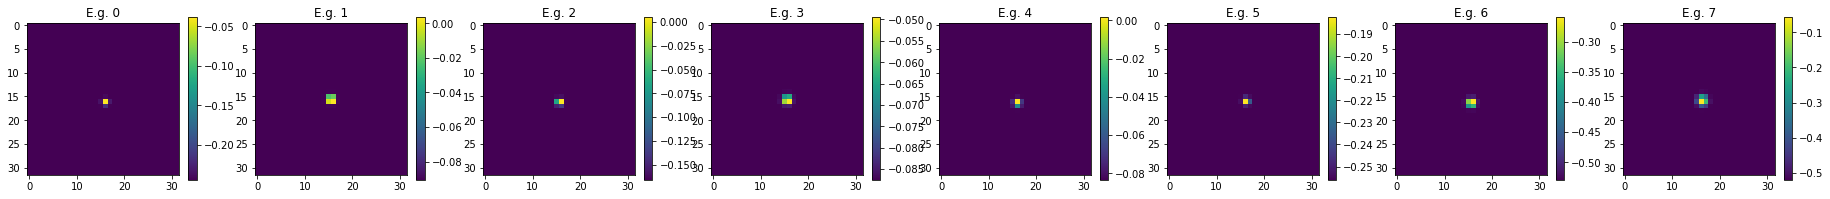

In [7]:
model.check_model(fitting_model, train_dataloader)
